In [17]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import keras
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [18]:
(X_train, _), (_, _) = fashion_mnist.load_data()

In [19]:
X_train = X_train.astype(np.float32) / 255.0
print(X_train.shape)
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [20]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [21]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [22]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [23]:
def summarize_performance(step, g_model, latent_dim,epoch_no, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = f'model_epoch_no_{epoch_no+1}.h5' 
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [24]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()


In [25]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = keras.layers.Input(shape=in_shape)
    fe = keras.layers.Flatten()(in_image)
    fe = keras.layers.Dense(1024)(fe)
    fe = keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe = keras.layers.Dropout(0.3)(fe)
    fe = keras.layers.Dense(512)(fe)
    fe = keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe = keras.layers.Dropout(0.3)(fe)
    fe = keras.layers.Dense(256)(fe)
    fe = keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe = keras.layers.Dropout(0.3)(fe)
    out = keras.layers.Dense(1, activation='sigmoid')(fe)
    model = keras.models.Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [26]:
discriminator = define_discriminator()

In [27]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = keras.layers.Input(shape=(latent_dim,)) 
    gen = keras.layers.Dense(256, kernel_initializer=init)(in_lat)
    gen = keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = keras.layers.Dense(512, kernel_initializer=init)(gen)
    gen = keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = keras.layers.Dense(1024, kernel_initializer=init)(gen)
    gen = keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = keras.layers.Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = keras.layers.Activation('tanh')(gen)
    out_layer = keras.layers.Reshape((28, 28, 1))(gen)
    model = keras.models.Model(in_lat, out_layer)
    return model
generator = define_generator(100)


In [28]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = keras.models.Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
gan_model = define_gan(generator, discriminator)


In [29]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    for epoch in range(n_epochs):
        for i in range(bat_per_epo):
            X_real, y_real = generate_real_samples(X_train, n_batch)
            d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
            z_input = generate_latent_points(latent_dim, n_batch) 
            y_gan = ones((n_batch, 1)) 
            g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
            print(epoch+1,',>%d, discriminator loss real, discriminator accuracy real[%.3f,%.3f], discriminator loss fake, discriminator accuracy fake[%.3f,%.3f], generator loss, generator accuracy[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
            if (i+1) % (bat_per_epo * 1) == 0:
                summarize_performance(i, g_model, latent_dim,epoch)

1 ,>1, discriminator loss real, discriminator accuracy real[0.420,1.000], discriminator loss fake, discriminator accuracy fake[0.702,0.016], generator loss, generator accuracy[0.686,0.984]
1 ,>2, discriminator loss real, discriminator accuracy real[0.129,1.000], discriminator loss fake, discriminator accuracy fake[0.712,0.000], generator loss, generator accuracy[0.678,1.000]


/home/user/anaconda3/envs/fr_36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 ,>3, discriminator loss real, discriminator accuracy real[0.058,1.000], discriminator loss fake, discriminator accuracy fake[0.727,0.000], generator loss, generator accuracy[0.665,1.000]
1 ,>4, discriminator loss real, discriminator accuracy real[0.044,1.000], discriminator loss fake, discriminator accuracy fake[0.745,0.000], generator loss, generator accuracy[0.653,1.000]
1 ,>5, discriminator loss real, discriminator accuracy real[0.047,1.000], discriminator loss fake, discriminator accuracy fake[0.771,0.000], generator loss, generator accuracy[0.633,1.000]
1 ,>6, discriminator loss real, discriminator accuracy real[0.034,1.000], discriminator loss fake, discriminator accuracy fake[0.795,0.000], generator loss, generator accuracy[0.618,1.000]
1 ,>7, discriminator loss real, discriminator accuracy real[0.026,1.000], discriminator loss fake, discriminator accuracy fake[0.825,0.000], generator loss, generator accuracy[0.612,1.000]
1 ,>8, discriminator loss real, discriminator accuracy 

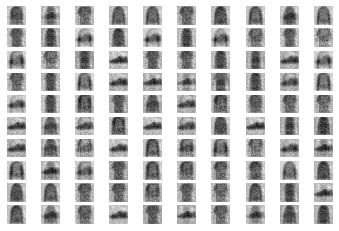

In [30]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=1, n_batch=64)

/home/user/anaconda3/envs/fr_36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/user/anaconda3/envs/fr_36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


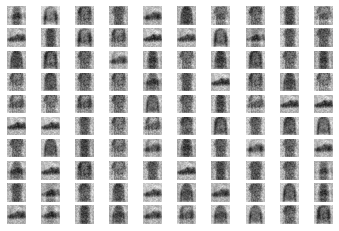

In [31]:
model = keras.models.load_model('model_epoch_no_1.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)